# Cross validation 과 GridSearch

교차 검증(Cross validation)을 Scikit-learn 라이브러리를 이용해서 어떻게 하는지 다뤄보고

모델링의 가장 최적의 하이퍼 파라미터 값을 찾기 위해 일일이 모두 다 해보는 방법이 아닌 Gridsearch를 코드상에서 어떻게 수행할수 있는지 알아보자

1. 일반적인 K-fold
2. startifoed K-fold
3. 단 한번에, cross_val_scroe !
4. GridSearchCV

## 1.일반적인 K-fold


일반적인 K-fold 교차 검증 방법은 아래의 그림과 같다

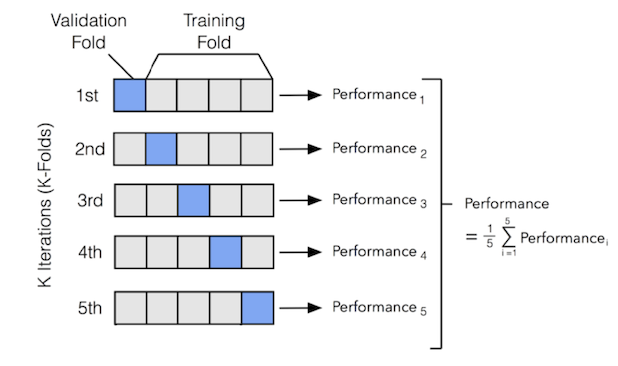

위 그림 처럼 Fold는 파란색 네모를 의미한다. 즉 만약 Fold 개수 (K값)를 5로 설정한다면 위 그림 처럼 5번의 모델링 검증을 시행할 것이다. 하지만 1번 검증을 시행할 때 마다 검증용 데이터가 각각 파란색으로 매번 달라진다. 그리고 모든 교차검증이 종료되고 즉, 5번의 검증이 종료된후 각 검증마다 도출된 정확도들의 평균값으로 최종적인 정확도를 계산하게 된다

이해가 안됐으면 밑에 설명을 한번 더 보자

* 첫 번째 폴드를 테스트 세트로 사용하고 나머지 폴드를 훈련세트로 사용하여 학습한다
* 나머지 훈련세트로 만덜어진 세트의 정확도를 첫번째 폴드로 평가한다
* 다음은 두 번째 폴드가 테스트 세트가 되고 나머지 폴드의 훈련세트를 두 번째 폴드로 정확도를 측정한다
* 이 과정을 마지막 폴드까지 반복한다
* 이렇게 훈련세트와 테스트세트로 나누는 N개의 분할마다 정확도를 측정하여 평균값을 낸게 정확도가 된다


* Scikit-learn 실습

In [ ]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer, load_boston

iris = load_iris()
wine = load_wine()
cancer = load_breast_cancer()

In [ ]:
# cross validation
# 일반적인 K-Fold cv
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


kf = KFold(n_splits=5)
all_acc = []
fold_idx = 0

features = iris.data
labels = iris.target

for train_idx, test_idx in kf.split(features):
    
    train_x, train_y = features[train_idx], labels[train_idx]
    test_x, test_y = features[test_idx], labels[test_idx]
    
    model = DecisionTreeClassifier()
    model.fit(train_x, train_y)
    pred_y = model.predict(test_x)
    acc = accuracy_score(test_y, pred_y)
    
    fold_idx += 1
    
    all_acc.append(acc)

print(f"KFold 모두 수행 후 평균 예측도 : {np.mean(all_acc)}")

KFold 모두 수행 후 평균 예측도 : 0.9066666666666666


## 2.Stratified K-fold

'Stratified'의 사전적 정의는 '층화된' 이라는 의미이다. 사전적인 의미만 봐서는 피부에 와닿게 이해가 되지 않는다. **Stratified K-fold 방법은 Train 데이터에서의 label(정답) 분포가 Test 데이터에서의 label(정답) 분포와 유사하도록 맞춰주는** 교차검증 방법이다

단적인 예로 원본 데이터의 label의 종류에 ['개', '고양이', '원숭이'] 가 있다고 하자.

모델이 학습하는Train 데이터에서의 label종류가['개','고양이']밖에 없는 상태로 학습이 진행되었다. 그리고 이제 Test데이터로 검증을 실시해야한다. 

그런데 Test 데이터로 검증할 떄 갑자기['원숭이'] 라는 label이 등장한다. 


모델은 학습할때는 분명히 '개' 또는 '고양이' 밖에 보지 못했는데 '원숭이'가 등장했을때 몹시 당황할 것이고 아마 정답을 맞추지 못할 것이다. 

매우 극단적인 예시지만앞서 설명했던 상황을 방지하기 위해서 **Stratified K-fold 방법은 Train, Test 데이터 각각에['개', '고양이', 원숭이']label들을 유사한 비율로 분포 하도록 Train, Test 데이터를 나누고 모델 검증을 하게된다**

* Stratified K-fold 실습

In [ ]:
# Stratified Cross validation

from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
all_acc = []
fold_idx = 0

features = iris.data
labels = iris.target

for train_idx, test_idx in skf.split(features, labels):

  train_x, train_y = features[train_idx], labels[train_idx]
  test_x, test_y = features[test_idx], labels[test_idx]

  model = DecisionTreeClassifier()
  model.fit(train_x, train_y)
  pred_y = model.predict(test_x)
  acc = accuracy_score(test_y, pred_y)

  fold_idx += 1
  all_acc.append(acc)

print(f"KFold 모두 수행 후 평균 예측도 :{np.mean(all_acc)}")

KFold 모두 수행 후 평균 예측도 :0.9600000000000002


K-fold 에 비해 예측도가 올라갔음을 알수있다

## 3.Cross_val_score

지금까지 살펴보았던 일반적인 K-fold, Stratified K-fold를 구현하기 위해서 어느정도 코드를 입력해야하는 수고가 든다.

하지만 이를 단하나의 함수로 해결해줄 수 있는 Cross_val_score 함수가 있다.


In [ ]:
# cross_val_score로 집약해서 교차검증

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, cross_validate
import numpy as np

iris_data = load_iris()
features = iris_data.data
labels = iris.target

model = DecisionTreeClassifier()

scores = cross_val_score(model, features, labels, scoring='accuracy', cv=5)



print(f"한번씩 검증 할 때마다 accuracy: {scores}")
print()
print(f"5번 모두 검증한 accuracy 총 평균 : {np.mean(scores)}")

한번씩 검증 할 때마다 accuracy: [0.96666667 0.96666667 0.9        0.96666667 1.        ]

5번 모두 검증한 accuracy 총 평균 : 0.9600000000000002


cross_val_score함수를 사용하게 된다면 이전처럼 for문을 사용하지 않는것이 눈에 띈다. 

즉 cross_val_score은 인자에 설정한 모델, features, label을 설정해주고 또 어떤 metric을 사용할지(위 예시에서는 분류 metric인 accruacy를 사용했다) 교차 검증을 몇 번 수행할지 까지 설정해준다. 참고로 cross _val_score에서 수행해주는 cross validation방법은 일반적인 K-fold가 아닌 Stratified K-fold 검증방법을 사용한다는 것을 알아두자

## 4.GridSearchCV(Gridsearch + cross validation)


GridSearch란, **모델링시 필요한 하이퍼파라미터 설정할 때 가장 최적의 파라미터값을 찾아주는 방법중 하나이다.** 그 중에서도GridSearch방법으 이른바 '무식하게 하나 하나 다 해보기'이다. 즉, **파라미터 후보값들을 사전에 정의 해주고 이를 일일이 for 문 처럼 돌려서 적용해보는 것을 대신 해주는 방법** 이다. 그리고 **추가적으로 교차 검증까지 수행** 해준다.

In [ ]:
# 최고의 Hyperparameter 찾기 위한 GridsearchCV 사용
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd

iris_data = load_iris()
train_x, test_x, train_y, test_y = train_test_split(iris_data.data,
                                                   iris_data.target,
                                                   test_size=0.2,
                                                   random_state=45)
model = DecisionTreeClassifier()
# parameter 넣어줄 값들 dict 형태로 정의해주기
h_para = {'max_depth':[1,2,3], 'min_samples_split':[2,3]}

grid_dtree = GridSearchCV(model, param_grid=h_para,
                         cv=5, refit=True, return_train_score=True)
# GridSearchCV 인자설명
# cv = 하나의 파라미터 쌍으로 모델링할 때 train, test 교차검증을 5번실시하겠다는 뜻
# refit=True : GridSearch한 후 가장 최고로 좋은 파라미터로 학습시켜 놓겠다.
# ㄴ> 이것 때문에 애초에 GridSearchCV 적용한 객체만으로 최적의 파라미터 적용된 모델로드 가능

# GridSearch 하면서 모든 파라미터값들에 대해 학습 수행
grid_dtree.fit(train_x, train_y)

# 각 파라미터값들에 대한 모델 결과값들이 cv_results_ 객체에 할당됨
scores_df = pd.DataFrame(grid_dtree.cv_results_)

# score 결과값(ndarray형태로 할당됨) 중 특정 칼럼들만 가져오기 
scores_df[['params', 'mean_test_score', 'rank_test_score', 
           'split0_test_score', 'split1_test_score', 'split2_test_score']]



,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.683333,5,0.666667,0.708333,0.708333
1,"{'max_depth': 1, 'min_samples_split': 3}",0.683333,5,0.666667,0.708333,0.708333
2,"{'max_depth': 2, 'min_samples_split': 2}",0.966667,1,0.958333,1.000000,0.916667
3,"{'max_depth': 2, 'min_samples_split': 3}",0.966667,1,0.958333,1.000000,0.916667
4,"{'max_depth': 3, 'min_samples_split': 2}",0.941667,3,0.958333,0.958333,0.916667
5,"{'max_depth': 3, 'min_samples_split': 3}",0.941667,3,0.958333,0.958333,0.916667


위 DatFream은 각각의 하이퍼파라미터 조합을 일일이 적용해서 도출된 각 모델링들의 성능을 결과표로 정리한 것이다.(원래 반환해주는 결과값이 n차원의 array형태라서 pandas를 이용해 DataFrame을 만들어준 것이다.(참고로 파라미터값의 종류 즉, max_depth, min_samples_split인 이윤는 사용하는 모델이 Decision Tree이기 때문이다.)

In [ ]:
# 최적의 파라미터는 best_params_에 할당되어있음
print(f"최적의 파라미터 : {grid_dtree.best_params_}")
print(f"최적의 파라미터로 모델의 정확도 : {grid_dtree.best_score_}")

print()
print()

# 최적의 파라미터로 학습되어 있는 모델링 할당
estimator = grid_dtree.best_estimator_

# 최적의 모델로 예측해보고 실제값이랑 정확도 비교
pred_y = estimator.predict(test_x)
print(f"실제값과 예측값 정확도 : {accuracy_score(test_y, pred_y)}")


최적의 파라미터 : {'max_depth': 2, 'min_samples_split': 2}
최적의 파라미터로 모델의 정확도 : 0.9666666666666668


실제값과 예측값 정확도 : 0.9333333333333333
